In [26]:
import cv2
import numpy as np

# Load template and video
template = cv2.imread('./materials/cow.png', cv2.IMREAD_GRAYSCALE)
template = cv2.resize(template, (80, 80))  # Resize the template to match the frame size
cv2.imshow("krowa", template)  # Display the resized template

# Edge detection for template
template_edges = cv2.Canny(template, 50, 150)
template_height, template_width = template_edges.shape

video = cv2.VideoCapture('./materials/upright.mp4')
target_width, target_height = 1024, 768

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    frame = cv2.resize(frame, (1024, 768))
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_edges = cv2.Canny(gray_frame, 50, 150)

    # Template matching
    res = cv2.matchTemplate(frame_edges, template_edges, cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # Draw result if match is found
    if max_val > 0.:  # Set a threshold for valid matches
        top_left = max_loc
        bottom_right = (top_left[0] + template_width, top_left[1] + template_height)

        cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
        cv2.putText(frame, f'Score: {max_val:.2f}', (top_left[0], top_left[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display frame
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()


In [46]:
import cv2
import numpy as np

# Load template and video
template = cv2.imread('./materials/rabbit.png', cv2.IMREAD_GRAYSCALE)
template = cv2.resize(template, (80, 80))  # Resize the template to match the frame size
template_edges = cv2.Canny(template, 50, 150)
template_height, template_width = template_edges.shape

video = cv2.VideoCapture('./materials/uppig.mov')
target_width, target_height = 1024, 768

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
    frame = cv2.resize(frame, (1024, 768))
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_edges = cv2.Canny(gray_frame, 50, 150)

    cv2.imshow("template", frame_edges)

    # Template matching
    res = cv2.matchTemplate(frame_edges, template_edges, cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    threshold = 0.3  # Set a threshold for valid matches
    locations = np.where(res >= threshold)

    for pt in zip(*locations[::-1]):
        top_left = pt
        bottom_right = (top_left[0] + template_width, top_left[1] + template_height)
        cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
        cv2.putText(frame, f'Score: {res[pt[::-1]]:.2f}', (top_left[0], top_left[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display frame
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()


## hough

In [3]:
import cv2
import numpy as np
from collections import Counter

def get_dominant_color(image, mask):
    # Extract colors within the mask
    colors = image[mask == 255]
    if len(colors) == 0:
        return (0, 0, 0)  # Default if no pixels found in mask

    # Convert to a list of tuples and count frequencies
    colors = [tuple(color) for color in colors]
    most_common_color = Counter(colors).most_common(1)[0][0]

    return most_common_color

def detect_circles_and_colors(video_path):
    # Open video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)

        # Detect circles using HoughCircles
        circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, param1=100, param2=50, minRadius=10, maxRadius=100)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for circle in circles[0, :]:
                x, y, r = circle

                # Create a circular mask for the detected circle
                mask = np.zeros_like(gray, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)

                # Get dominant color inside the circle
                dominant_color = get_dominant_color(frame, mask)
                color_name = f"RGB({dominant_color[2]}, {dominant_color[1]}, {dominant_color[0]})"

                # Draw the circle and bounding box
                cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
                cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (0, 255, 0), -1)

                # Put text (dominant color)
                cv2.putText(frame, color_name, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

        # Show the frame
        cv2.imshow("Circles and Colors", frame)

        # Exit on pressing 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Replace 'video.mp4' with the path to your video file
detect_circles_and_colors('./materials/upright.mp4')


In [12]:
import cv2
import numpy as np

def detect_circles_in_first_frame(video_path, target_size=45, tolerance=3):
    # Open video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, param1=50, param2=30, minRadius=40, maxRadius=48)   #Hardcoded for upright.mp4. Try to get size of board and have variables?

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            x, y, r = circle

            cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
            cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (0, 255, 0), -1)

            # Put text (circle size)
            size_text = f"Size: {r}"
            cv2.putText(frame, size_text, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    # Show the frame
    cv2.imshow("Circles in First Frame", frame)

    # Wait for user to close the window
    cv2.waitKey(0)

    cap.release()
    cv2.destroyAllWindows()

# Replace 'video.mp4' with the path to your video file
detect_circles_in_first_frame('./materials/upright.mp4')


# trying with distortions, board variables

In [49]:
import cv2
import numpy as np

def undistort_frame(frame, camera_matrix, dist_coeffs):
    h, w = frame.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    undistorted_frame = cv2.undistort(frame, camera_matrix, dist_coeffs, None, new_camera_matrix)
    x, y, w, h = roi
    return undistorted_frame[y:y+h, x:x+w]

def detect_board_and_calibrate(frame):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect edges to find the board
    edges = cv2.Canny(gray, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Look for quadrilateral shapes (the board)
        if len(approx) == 4:
            board = approx
            return board

    return None

def compute_circle_size_from_board(board):
    # Compute board dimensions (assumes rectangle in perspective)
    distances = [
        np.linalg.norm(board[i][0] - board[(i+1) % 4][0]) for i in range(4)
    ]
    avg_distance = sum(distances) / len(distances)

    # Define circle size based on average board dimension
    return avg_distance / 10  # Adjustable scale factor

def detect_circles_in_first_frame(video_path, camera_matrix, dist_coeffs):
    # Open video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    # Undistort the frame
    frame = undistort_frame(frame, camera_matrix, dist_coeffs)

    # Detect the board
    board = detect_board_and_calibrate(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    # Compute circle size
    circle_size = compute_circle_size_from_board(board)
    tolerance = 0.1 * circle_size  # 10% tolerance

    # Draw the board on the frame
    cv2.polylines(frame, [board], isClosed=True, color=(255, 0, 255), thickness=4)

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=50, param2=30, minRadius=int(circle_size - tolerance), maxRadius=int(circle_size + tolerance))

    if circles is not None:
        circles = np.uint16(np.around(circles))
        detected_circles = []

        for circle in circles[0, :]:
            x, y, r = circle

            # Check for overlapping circles
            overlap = False
            for detected in detected_circles:
                dx, dy, dr = detected
                if np.sqrt((x - dx) ** 2 + (y - dy) ** 2) < 50:
                    overlap = True
                    break

            if not overlap:
                detected_circles.append((x, y, r))

                # Draw the circle and bounding box
                cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
                cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (0, 255, 0), -1)

                # Put text (circle size)
                size_text = f"Size: {r}"
                cv2.putText(frame, size_text, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    # Show the frame
    cv2.imshow("Circles in First Frame", frame)

    # Wait for user to close the window
    cv2.waitKey(0)

    cap.release()
    cv2.destroyAllWindows()

# Example intrinsic camera matrix and distortion coefficients
camera_matrix = np.array([
    [1000, 0, 640],
    [0, 1000, 360],
    [0, 0, 1]
], dtype=np.float32)
dist_coeffs = np.zeros(5)  # Assuming no lens distortion

# Replace 'video.mp4' with the path to your video file
detect_circles_in_first_frame('./materials/upright.mp4', camera_matrix, dist_coeffs)


C:\Users\mary9\AppData\Local\Temp\ipykernel_23948\3284269402.py:95: RuntimeWarning: overflow encountered in scalar subtract
  if np.sqrt((x - dx) ** 2 + (y - dy) ** 2) < 50:
C:\Users\mary9\AppData\Local\Temp\ipykernel_23948\3284269402.py:95: RuntimeWarning: invalid value encountered in sqrt
  if np.sqrt((x - dx) ** 2 + (y - dy) ** 2) < 50:


# ### detects all animals/circles based on board size 


In [ ]:
# ### detects all animals/circles based on board size 
# import cv2 
# import numpy 

# def detect_board_and_calibrate(frame):
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     edges = cv2.Canny(gray, 50, 150)

#     # Find contours
#     contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     for contour in contours:
#         # Approximate the contour to a polygon
#         epsilon = 0.02 * cv2.arcLength(contour, True)
#         approx = cv2.approxPolyDP(contour, epsilon, True)

#         if len(approx) == 4:
#             board = approx
#             return board

#     return None

# def compute_circle_size_from_board(board):
#     # Compute board dimensions (assumes rectangle in perspective)
#     distances = [
#         np.linalg.norm(board[i][0] - board[(i+1) % 4][0]) for i in range(4)
#     ]
#     avg_distance = sum(distances) / len(distances)

#     # Define circle size based on average board dimension
#     return avg_distance / 12  

# def detect_circles_in_video(video_path):
#     cap = cv2.VideoCapture(video_path)
#     if not cap.isOpened():
#         print("Error: Could not open video.")
#         return

#     # Read the first frame to calibrate
#     ret, frame = cap.read()
#     if not ret:
#         print("Error: Could not read the first frame.")
#         cap.release()
#         return
    
#     # Detect the board
#     board = detect_board_and_calibrate(frame)
#     if board is None:
#         print("Error: Could not detect the board.")
#         cap.release()
#         return

#     # Compute circle size based on the board dimentions
#     circle_size = compute_circle_size_from_board(board)
#     tolerance = 0.07 * circle_size  

#     while True:
#         # Read next frame
#         ret, frame = cap.read()
#         if not ret:
#             break

#         gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#         # Apply Gaussian blur
#         blurred = cv2.GaussianBlur(gray, (9, 9), 2)

#         # Detect circles using HoughCircles
#         circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=50, param2=30, minRadius=int(circle_size - tolerance), maxRadius=int(circle_size + tolerance))

#         if circles is not None:
#             circles = np.uint16(np.around(circles))
#             detected_circles = []

#             for circle in circles[0, :]:
#                 x, y, r = circle

#                 # Check for overlapping circles
#                 overlap = False
#                 for detected in detected_circles:
#                     dx, dy, dr = detected
#                     if np.sqrt((x - dx) ** 2 + (y - dy) ** 2) < 50:
#                         overlap = True
#                         break

#                 if not overlap:
#                     detected_circles.append((x, y, r))

#                     # Draw the circle and bounding box
#                     cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
#                     cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (0, 255, 0), -1)

#                     # Put text (circle size)
#                     size_text = f"Size: {r}"
#                     cv2.putText(frame, size_text, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

#         cv2.imshow("Circles in Video", frame)

#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()


# detect_circles_in_video('./materials/upright.mp4')


C:\Users\mary9\AppData\Local\Temp\ipykernel_23948\2411535690.py:81: RuntimeWarning: overflow encountered in scalar subtract
  if np.sqrt((x - dx) ** 2 + (y - dy) ** 2) < 50:
C:\Users\mary9\AppData\Local\Temp\ipykernel_23948\2411535690.py:81: RuntimeWarning: invalid value encountered in sqrt
  if np.sqrt((x - dx) ** 2 + (y - dy) ** 2) < 50:


# Dice roll event, need border exclusion

In [3]:
import cv2
import numpy as np
import time

video_path = "./materials/lik.mov"
game = cv2.VideoCapture(video_path)
if game.isOpened():
    print("Video loaded")

target_width, target_height = 1024, 768
original_width = int(game.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(game.get(cv2.CAP_PROP_FRAME_HEIGHT))
game_fps = game.get(cv2.CAP_PROP_FPS)
scale_x = target_width / original_width
scale_y = target_height / original_height
output_path = "./output/track_1.avi"
output_video = cv2.VideoWriter(
    output_path,
    cv2.VideoWriter_fourcc(*"DIVX"),
    game_fps,
    (target_width, target_height),
)

#Color definition
orange_lower = np.array([7, 66, 114])  # Lower bound for orange
orange_upper = np.array([10, 252, 253])  # Upper bound for orange
blue_lower = np.array([90, 80, 100])    # Lower bound for light blue
blue_upper = np.array([120, 255, 255])   # Upper bound for light blue


trackers = []
tracker_start_times = {}

def create_tracker(tracker_type="CSRT"):
    if tracker_type == "CSRT":
        return cv2.TrackerCSRT_create()
    elif tracker_type == "KCF":
        return cv2.TrackerKCF_create()
    return None

def draw_bbox_with_area(frame, bbox, text, color=(255, 255, 255)):
    """Draws a bounding box and displays its area."""
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)
    text_position = (p1[0], max(0, p1[1] - 10))
    cv2.putText(
        frame,
        f"{text}",
        text_position,
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        color,
        1,
        cv2.LINE_AA,
    )

def is_square(bbox, tolerance=0.2):
    x, y, w, h = bbox
    aspect_ratio = w / h if w > h else h / w
    return 1 - tolerance <= aspect_ratio <= 1 + tolerance

def is_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]  # Extract ROI
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)  # Convert ROI to HSV
    orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
    orange_pixels = cv2.countNonZero(orange_mask)
    blue_pixels = cv2.countNonZero(blue_mask)
    total_pixels = w * h
    return (orange_pixels + blue_pixels) / total_pixels >= threshold

def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            board = approx
            cv2.drawContours(frame, [board], -1, (255, 0, 255), 4)
            return board

    return None


# Start tracking
while game.isOpened():
    ret, frame = game.read()
    if not ret:
        break

    frame = cv2.resize(frame, (target_width, target_height))
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
    combined_mask = cv2.bitwise_or(orange_mask, blue_mask)

    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detected_bboxes = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if 1000 < area < 4500:  # Area thresholds
            x, y, w, h = cv2.boundingRect(contour)
            if is_square((x, y, w, h)):
                detected_bboxes.append((x, y, w, h, area))

    current_time = time.time()
    
    for bbox_data in detected_bboxes:
        bbox = bbox_data[:4]
        area = bbox_data[4]
        is_new = True
        for tracker, tracked_bbox in trackers:
            if is_overlap(bbox, tracked_bbox):
                is_new = False
                break

        if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
            tracker = create_tracker("KCF")
            tracker.init(frame, bbox)
            trackers.append((tracker, bbox))
            tracker_start_times[tracker] = current_time
            print(f"New dice detected and tracking initialized at {bbox}")

    for i, (tracker, _) in enumerate(trackers):
        ok, bbox = tracker.update(frame)
        if ok:
            if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                trackers[i] = (tracker, bbox)
                area = bbox[2] * bbox[3]
                draw_bbox_with_area(frame, bbox, "Dice",(0, 255, 0))
                
                # If tracker is acrive for at least 2s => dice roll
                if current_time - tracker_start_times[tracker] >= 2:
                    text_position = (bbox[0], bbox[1] - 10)
                    cv2.putText(frame, "Dice Roll", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            else:
                # print(f"Tracker {i} lost valid target at {bbox}")
                trackers[i] = None
        else:
            # print(f"Tracker {i} failed at {bbox}")
            trackers[i] = None

    trackers = [t for t in trackers if t is not None]

    output_video.write(frame)
    cv2.imshow("Dice Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

game.release()
output_video.release()
cv2.destroyAllWindows()


Video loaded
New dice detected and tracking initialized at (989, 689, 35, 42)
New dice detected and tracking initialized at (960, 657, 64, 57)
New dice detected and tracking initialized at (883, 594, 60, 54)
New dice detected and tracking initialized at (843, 539, 61, 53)
New dice detected and tracking initialized at (848, 479, 66, 55)
New dice detected and tracking initialized at (864, 436, 61, 54)
New dice detected and tracking initialized at (874, 413, 70, 60)
New dice detected and tracking initialized at (895, 396, 74, 62)
New dice detected and tracking initialized at (930, 377, 73, 63)
New dice detected and tracking initialized at (941, 367, 76, 64)
New dice detected and tracking initialized at (964, 355, 60, 64)
New dice detected and tracking initialized at (968, 433, 56, 64)
New dice detected and tracking initialized at (930, 464, 75, 63)
New dice detected and tracking initialized at (706, 589, 69, 58)
New dice detected and tracking initialized at (790, 160, 73, 71)
New dice det

In [2]:
# import cv2
# import numpy as np
# import time

# video_path = "./materials/lik.mov"
# game = cv2.VideoCapture(video_path)
# if game.isOpened():
#     print("Video loaded")

# target_width, target_height = 1024, 768
# original_width = int(game.get(cv2.CAP_PROP_FRAME_WIDTH))
# original_height = int(game.get(cv2.CAP_PROP_FRAME_HEIGHT))
# game_fps = game.get(cv2.CAP_PROP_FPS)
# scale_x = target_width / original_width
# scale_y = target_height / original_height
# output_path = "./output/track_1.avi"
# output_video = cv2.VideoWriter(
#     output_path,
#     cv2.VideoWriter_fourcc(*"DIVX"),
#     game_fps,
#     (target_width, target_height),
# )

# # Color definition
# orange_lower = np.array([7, 66, 114])  # Lower bound for orange
# orange_upper = np.array([10, 252, 253])  # Upper bound for orange
# blue_lower = np.array([90, 80, 100])    # Lower bound for light blue
# blue_upper = np.array([120, 255, 255])  # Upper bound for light blue

# trackers = []
# tracker_start_times = {}

# def create_tracker(tracker_type="KCF"):
#     if tracker_type == "CSRT":
#         return cv2.TrackerCSRT_create()
#     elif tracker_type == "KCF":
#         return cv2.TrackerKCF_create()
#     return None

# def draw_bbox_with_area(frame, bbox, text, color=(255, 255, 255)):
#     p1 = (int(bbox[0]), int(bbox[1]))
#     p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
#     cv2.rectangle(frame, p1, p2, color, 2, 1)
#     text_position = (p1[0], max(0, p1[1] - 10))
#     cv2.putText(
#         frame,
#         f"{text}",
#         text_position,
#         cv2.FONT_HERSHEY_SIMPLEX,
#         0.5,
#         color,
#         1,
#         cv2.LINE_AA,
#     )

# def is_square(bbox, tolerance=0.2):
#     x, y, w, h = bbox
#     aspect_ratio = w / h if w > h else h / w
#     return 1 - tolerance <= aspect_ratio <= 1 + tolerance

# def is_overlap(bbox1, bbox2):
#     x1, y1, w1, h1 = bbox1
#     x2, y2, w2, h2 = bbox2
#     return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

# def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
#     x, y, w, h = bbox
#     roi = frame[y:y+h, x:x+w]  # Extract ROI
#     hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)  # Convert ROI to HSV
#     orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
#     blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
#     orange_pixels = cv2.countNonZero(orange_mask)
#     blue_pixels = cv2.countNonZero(blue_mask)
#     total_pixels = w * h
#     return (orange_pixels + blue_pixels) / total_pixels >= threshold

# def detect_board(frame):
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     edges = cv2.Canny(gray, 50, 150)
#     contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     for contour in contours:
#         epsilon = 0.02 * cv2.arcLength(contour, True)
#         approx = cv2.approxPolyDP(contour, epsilon, True)
#         if len(approx) == 4:
#             board = approx
#             cv2.drawContours(frame, [board], -1, (255, 0, 255), 2)
#             return board  # Return bounding box of the board

#     return None

# # Start tracking
# while game.isOpened():
#     ret, frame = game.read()
#     if not ret:
#         break

#     frame = cv2.resize(frame, (target_width, target_height))

#     # Detect the board and draw its contour
#     board_bbox = detect_board(frame)
#     print(board_bbox)
#     if board_bbox is not None:
#         top_ = board_bbox
#         cv2.drawContours(frame, board_bbox, -1, (255, 0, 255), 2)  # Draw board contour

#     hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

#     orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
#     blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
#     combined_mask = cv2.bitwise_or(orange_mask, blue_mask)

#     contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     detected_bboxes = []

#     for contour in contours:
#         area = cv2.contourArea(contour)
#         if 1000 < area < 4500:  # Area thresholds
#             x, y, w, h = cv2.boundingRect(contour)
#             if is_square((x, y, w, h)):
#                 dice_bbox = (x, y, w, h)
#                 # Check if dice overlaps with the board
#                 if not is_overlap(dice_bbox, board_bbox):
#                     detected_bboxes.append((x, y, w, h, area))

#     current_time = time.time()

#     for bbox_data in detected_bboxes:
#         bbox = bbox_data[:4]
#         area = bbox_data[4]
#         is_new = True
#         for tracker, tracked_bbox in trackers:
#             if is_overlap(bbox, tracked_bbox):
#                 is_new = False
#                 break

#         if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
#             tracker = create_tracker("KCF")
#             tracker.init(frame, bbox)
#             trackers.append((tracker, bbox))
#             tracker_start_times[tracker] = current_time
#             print(f"New dice detected and tracking initialized at {bbox}")

#     for i, (tracker, _) in enumerate(trackers):
#         ok, bbox = tracker.update(frame)
#         if ok:
#             if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
#                 trackers[i] = (tracker, bbox)
#                 area = bbox[2] * bbox[3]
#                 draw_bbox_with_area(frame, bbox, "Dice", (0, 255, 0))
                
#                 # If tracker is active for at least 2s => dice roll
#                 if current_time - tracker_start_times[tracker] >= 2:
#                     text_position = (bbox[0], bbox[1] - 10)
#                     cv2.putText(frame, "Dice Roll", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
#             else:
#                 trackers[i] = None
#         else:
#             trackers[i] = None

#     trackers = [t for t in trackers if t is not None]

#     output_video.write(frame)
#     cv2.imshow("Dice Tracking", frame)

#     if cv2.waitKey(1) & 0xFF == ord("q"):
#         break

# game.release()
# output_video.release()
# cv2.destroyAllWindows()


Video loaded
[[[611 767]]

 [[614 765]]

 [[637 765]]

 [[614 765]]]
[[[611 767]]

 [[614 765]]

 [[637 765]]

 [[614 765]]]
[[[611 767]]

 [[614 765]]

 [[637 765]]

 [[614 765]]]
[[[611 767]]

 [[614 765]]

 [[637 765]]

 [[614 765]]]
[[[611 767]]

 [[614 765]]

 [[637 765]]

 [[614 765]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 61 641]]

 [[ 52 640]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 61 641]]

 [[ 52 640]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 61 641]]

 [[ 52 640]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 61 641]]

 [[ 52 640]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 61 641]]

 [[ 52 640]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 61 641]]

 [[ 52 640]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 61 641]]

 [[ 52 640]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 61 641]]

 [[ 52 640]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 61 641]]

 [[ 52 640]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 61 641]]

 [[ 52 640]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 62 641]]

 [[ 52 640]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 61 641]]

 [[ 52 640]]]
[[[ 46 638]]

 [[ 52 640]]

 [[ 61 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

: 

# WORKING ON DETECTING ANIMALS BY COLOR

##### THIS DETECTS BOARD IN EACH FRAME, DETECT CIRCLES AND THEIR COLORS

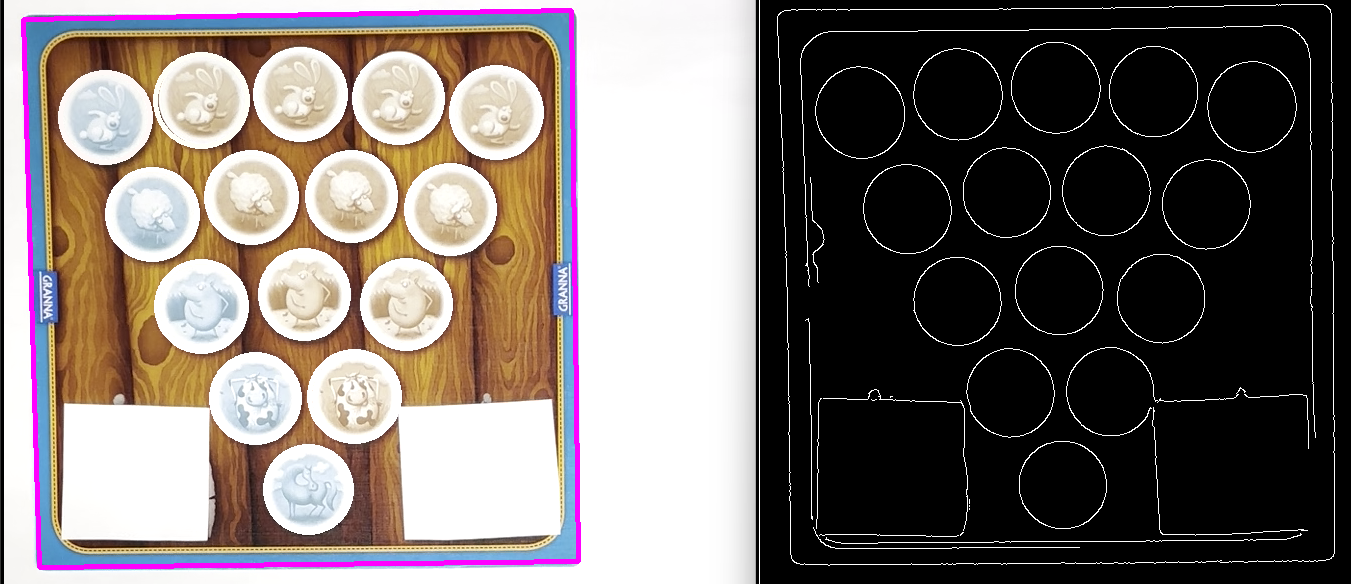

In [102]:
# ### THIS DETECTS BOARD IN EACH FRAME, DETECT CIRCLES AND THEIR COLORS
# import cv2 
# import numpy as np
# from scipy.stats import mode

# def detect_board(frame):
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     gray = cv2.GaussianBlur(gray, (9, 9), 3)
#     edges = cv2.Canny(gray, 50, 150)

#     # Find contours
#     contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cv2.imshow("sd", edges)

#     for contour in contours:
#         # Approximate the contour to a polygon
#         epsilon = 0.02 * cv2.arcLength(contour, True)
#         approx = cv2.approxPolyDP(contour, epsilon, True)

#         if len(approx) == 4:
#             # Calculate the bounding box
#             x, y, w, h = cv2.boundingRect(approx)
#             aspect_ratio = w / float(h)

#             # Check aspect ratio and solidity
#             if 0.95 <= aspect_ratio <= 1.05:  # Allowing some tolerance for a square
#                 if cv2.isContourConvex(approx):  # Check contour solidity
#                     board = approx
#                     return board

#     return None



# def get_dominant_color(frame, mask):
#     # Flatten the mask and the frame for easier indexing
#     mask_flat = mask.flatten()
#     frame_flat = frame.reshape((-1, 3))

#     # Select the pixels in the masked region
#     color_mask = frame_flat[mask_flat == 255]

#     # Check if any pixels are selected
#     if color_mask.size == 0:
#         return (0, 0, 0)  # Default to black if the mask region is empty

#     # Find the mode (most frequent color) in each channel
#     dominant_color = mode(color_mask, axis=0, keepdims=False).mode

#     # Ensure the result is a tuple
#     return tuple(map(int, dominant_color))


# def compute_circle_size_from_board(board):
#     # Compute board dimensions (assumes rectangle in perspective)
#     distances = [
#         np.linalg.norm(board[i][0] - board[(i+1) % 4][0]) for i in range(4)
#     ]
#     avg_distance = sum(distances) / len(distances)

#     # Define circle size based on average board dimension
#     return avg_distance / 12  

# def detect_circles_in_video(video_path):
#     cap = cv2.VideoCapture(video_path)
#     if not cap.isOpened():
#         print("Error: Could not open video.")
#         return

#     # Read the first frame to calibrate
#     ret, frame = cap.read()
#     if not ret:
#         print("Error: Could not read the first frame.")
#         cap.release()
#         return
    
#     # Detect the board
#     board = detect_board(frame)
#     print(board)
#     if board is None:
#         print("Error: Could not detect the board.")
#         cap.release()
#         return

#     # Compute circle size based on the board dimentions
#     circle_size = compute_circle_size_from_board(board)
#     tolerance = 0.07 * circle_size  

#     while True:
#         # Read next frame
#         ret, frame = cap.read()
#         if not ret:
#             break
#         board = detect_board(frame)
#         if board is not None:
#             cv2.polylines(frame, [board], isClosed=True, color=(255, 0, 255), thickness=4)
        

#         gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#         # Apply Gaussian blur
#         blurred = cv2.GaussianBlur(gray, (9, 9), 2)

#         # Detect circles using HoughCircles
#         circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=70, param2=30, minRadius=int(circle_size - tolerance), maxRadius=int(circle_size + tolerance))

#         if circles is not None:
#             circles = np.uint16(np.around(circles))
            
#             detected_circles = []
#             for circle in circles[0, :]:
#                 x, y, r = circle

#                 # Create a circular mask for the detected circle
#                 mask = np.zeros_like(gray, dtype=np.uint8)
#                 cv2.circle(mask, (x, y), r, 255, -1)

#                 # Get dominant color inside the circle
#                 dominant_color = get_dominant_color(frame, mask)
#                 # color_name = f"({dominant_color[2]}, {dominant_color[1]}, {dominant_color[0]})"
#                 color_name = f"({dominant_color})"
                
#                 # Draw the circle and bounding box
#                 cv2.circle(frame, (x, y), r, (int(dominant_color[0]), int(dominant_color[1]), int(dominant_color[2])), 4)

            
#         cv2.imshow("Circles in Video", frame)

#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()


# # detect_circles_in_video('./materials/upright.mp4')
# detect_circles_in_video('./materials/uppig.mov')



[[[570 159]]

 [[ 22 169]]

 [[ 38 716]]

 [[577 710]]]


THIS DETECTS BOARD, puts tracker on it, DETECT CIRCLES AND THEIR COLORS

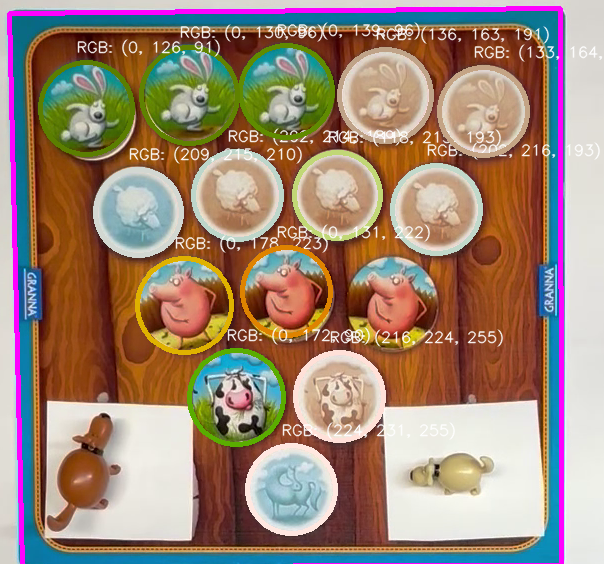

In [100]:
import cv2
import numpy as np
from scipy.stats import mode

def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 2)
    edges = cv2.Canny(gray, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)

            if 0.95 <= aspect_ratio <= 1.05 and cv2.isContourConvex(approx):
                return approx

    return None

def get_dominant_color(frame, mask):
    mask_flat = mask.flatten()
    frame_flat = frame.reshape((-1, 3))
    color_mask = frame_flat[mask_flat == 255]

    if color_mask.size == 0:
        return (0, 0, 0)

    dominant_color = mode(color_mask, axis=0, keepdims=False).mode
    return tuple(map(int, dominant_color))

def compute_circle_size_from_board(board):
    distances = [np.linalg.norm(board[i][0] - board[(i+1) % 4][0]) for i in range(4)]
    avg_distance = sum(distances) / len(distances)
    return avg_distance / 12

def detect_circles_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    x, y, w, h = cv2.boundingRect(board.reshape(-1, 2))
    tracker = cv2.TrackerCSRT_create()
    tracker.init(frame, (x, y, w, h))

    circle_size = compute_circle_size_from_board(board)
    tolerance = 0.07 * circle_size  

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if frame_count % 2 != 0:  # Process every 2nd frame
            continue

        success, board_bbox = tracker.update(frame)
        if not success:
            print("Board lost, re-detecting...")
            board = detect_board(frame)
            if board is not None:
                x, y, w, h = cv2.boundingRect(board.reshape(-1, 2))
                tracker = cv2.TrackerCSRT_create()
                tracker.init(frame, (x, y, w, h))
            else:
                continue

        if board is not None:
            cv2.polylines(frame, [board], isClosed=True, color=(255, 0, 255), thickness=4)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)
        circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=70, param2=30, minRadius=int(circle_size - tolerance), maxRadius=int(circle_size + tolerance))

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for circle in circles[0, :]:
                x, y, r = circle
                mask = np.zeros_like(gray, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)
                dominant_color = get_dominant_color(frame, mask)
                color_text = f"RGB: ({dominant_color[0]}, {dominant_color[1]}, {dominant_color[2]})"
                cv2.circle(frame, (x, y), r, (int(dominant_color[0]), int(dominant_color[1]), int(dominant_color[2])), 4)
                cv2.putText(frame, color_text, (x - 10, y - r - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        cv2.imshow("Circles in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

detect_circles_in_video('./materials/upright.mp4')
# detect_circles_in_video('./materials/uppig.mov')


# Trying to crack dog detection

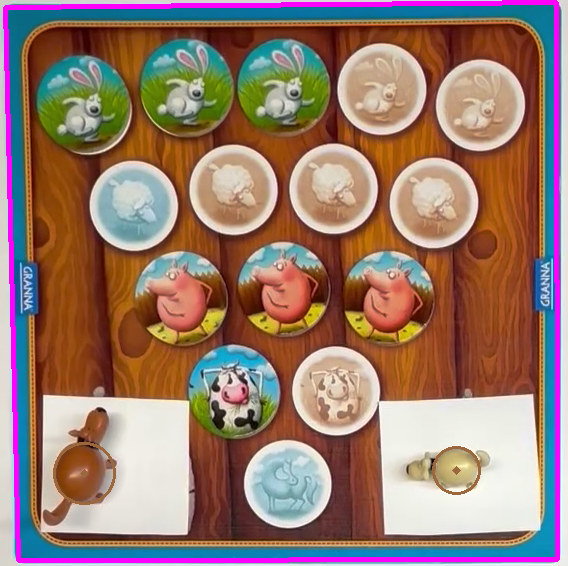

In [98]:
### DETECTS DARK DOG, NUMBER OF PIXELS IN LEFT BOTTOM: >500 FOR DARKER SHADE 
import cv2
import numpy as np
from scipy.stats import mode

def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 2)
    edges = cv2.Canny(gray, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)

            if 0.95 <= aspect_ratio <= 1.05 and cv2.isContourConvex(approx):
                return approx, x, y, w, h  # Return bounding box dimensions as well

    return None, None, None, None, None


def get_dominant_color(frame, mask):
    mask_flat = mask.flatten()
    frame_flat = frame.reshape((-1, 3))
    color_mask = frame_flat[mask_flat == 255]

    if color_mask.size == 0:
        return (0, 0, 0)

    dominant_color = mode(color_mask, axis=0, keepdims=False).mode
    return tuple(map(int, dominant_color))

def compute_circle_size_from_board(board):
    distances = [np.linalg.norm(board[i][0] - board[(i+1) % 4][0]) for i in range(4)]
    avg_distance = sum(distances) / len(distances)
    return avg_distance / 12

def detect_circles_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[2]  # Bottom-left corner
    bottom_right = board_corners[3]  # Bottom-right corner
    square_side = int(w * 0.23)  # 1/5 of the board width/height
    roi_size = (square_side, square_side)

    tracker = cv2.TrackerCSRT_create()
    tracker.init(frame, (x, y, w, h))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        success, board_bbox = tracker.update(frame)
        if not success:
            print("Board lost, re-detecting...")
            board, x, y, w, h = detect_board(frame)
            if board is not None:
                tracker = cv2.TrackerCSRT_create()
                tracker.init(frame, (x, y, w, h))
                board_corners = board.reshape(4, 2)
                bottom_left = board_corners[2]  # Update bottom-left
                bottom_right = board_corners[3]  # Update bottom-right
            else:
                continue

        # Draw board
        cv2.polylines(frame, [board], isClosed=True, color=(255, 0, 255), thickness=4)

# Define region of interest shifted above corners
        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

        # Extract ROIs
        roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

        circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=5, maxRadius=50)

        circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=5, maxRadius=50)

#Drawing left dog
        if circles_left is not None:
            circles_left = np.uint16(np.around(circles_left))
            circles_left = sorted(circles_left[0, :], key=lambda c: -c[2])  # Sort by radius, descending to draw only the biggest circle
            if len(circles_left) > 0:
                largest_circle = circles_left[0]
                cv2.circle(roi_frame_left, (largest_circle[0], largest_circle[1]), largest_circle[2], (60, 103, 155), 2)
                cv2.circle(roi_frame_left, (largest_circle[0], largest_circle[1]), 2, (60, 103, 155), 3)

#Drawing right dog
        if circles_right is not None:
            circles_right = np.uint16(np.around(circles_right))
            circles_right = sorted(circles_right[0, :], key=lambda c: -c[2])  
            if len(circles_right) > 0:
                largest_circle = circles_right[0]
                cv2.circle(roi_frame_right, (largest_circle[0], largest_circle[1]), largest_circle[2], (60, 103, 155), 2)
                cv2.circle(roi_frame_right, (largest_circle[0], largest_circle[1]), 2, (60, 103, 155), 3)

        # Place the processed ROIs back into the frame
        frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
              roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]] = roi_frame_left
        frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
              roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]] = roi_frame_right

#visualisation of boxes where we're looking for dogs
        # cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
        # cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)

        cv2.imshow("Circles in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
detect_circles_in_video('./materials/upright.mp4')
# detect_circles_in_video('./materials/uppig.mov')


C:\Users\mary9\AppData\Local\Temp\ipykernel_31232\1211801601.py:123: RuntimeWarning: overflow encountered in scalar negative
  circles_left = sorted(circles_left[0, :], key=lambda c: -c[2])  # Sort by radius, descending to draw only the biggest circle
C:\Users\mary9\AppData\Local\Temp\ipykernel_31232\1211801601.py:132: RuntimeWarning: overflow encountered in scalar negative
  circles_right = sorted(circles_right[0, :], key=lambda c: -c[2])


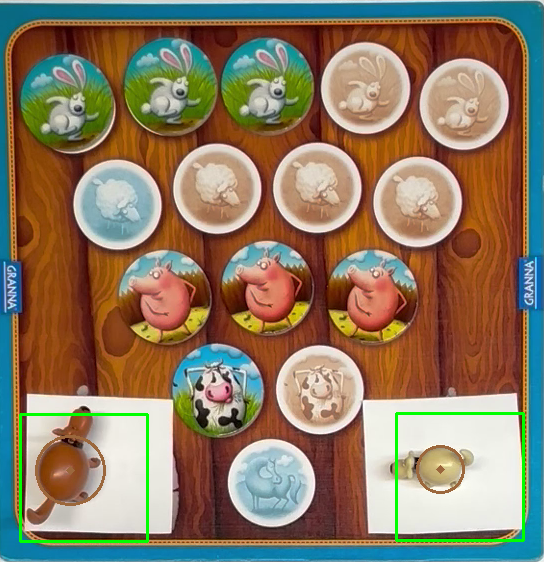

In [99]:
import cv2
import numpy as np

def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 2)
    edges = cv2.Canny(gray, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)

            if 0.95 <= aspect_ratio <= 1.05 and cv2.isContourConvex(approx):
                return approx, x, y, w, h  # Returning bounding box dimensions

    return None, None, None, None, None

def detect_circles_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[2]  # Bottom-left corner
    bottom_right = board_corners[3]  # Bottom-right corner
    square_side = int(w * 0.23)  # 1/5 of the board width/height
    roi_size = (square_side, square_side)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

        # Extract ROIs
        roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

        # Convert to grayscale for Hough Circles
        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

        circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=5, maxRadius=50)

        circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=5, maxRadius=50)

#Drawing left dog
        if circles_left is not None:
            circles_left = np.uint16(np.around(circles_left))
            circles_left = sorted(circles_left[0, :], key=lambda c: -c[2])  # Sort by radius, descending to draw only the biggest circle
            if len(circles_left) > 0:
                largest_circle = circles_left[0]
                cv2.circle(roi_frame_left, (largest_circle[0], largest_circle[1]), largest_circle[2], (60, 103, 155), 2)
                cv2.circle(roi_frame_left, (largest_circle[0], largest_circle[1]), 2, (60, 103, 155), 3)

#Drawing right dog
        if circles_right is not None:
            circles_right = np.uint16(np.around(circles_right))
            circles_right = sorted(circles_right[0, :], key=lambda c: -c[2])  
            if len(circles_right) > 0:
                largest_circle = circles_right[0]
                cv2.circle(roi_frame_right, (largest_circle[0], largest_circle[1]), largest_circle[2], (60, 103, 155), 2)
                cv2.circle(roi_frame_right, (largest_circle[0], largest_circle[1]), 2, (60, 103, 155), 3)

        # Place the processed ROIs back into the frame
        frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
              roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]] = roi_frame_left
        frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
              roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]] = roi_frame_right

#Visualisation of boxes of search for dogs
        cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (0, 255, 0), 2)
        cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (0, 255, 0), 2)

        cv2.imshow("Circles in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
detect_circles_in_video('./materials/upright.mp4')   #has 2 dogs at the start
# detect_circles_in_video('./materials/uppig.mov')    #NO dogs


C:\Users\mary9\AppData\Local\Temp\ipykernel_31232\3671512606.py:85: RuntimeWarning: overflow encountered in scalar negative
  circles_left = sorted(circles_left[0, :], key=lambda c: -c[2])  # Sort by radius, descending to draw only the biggest circle
C:\Users\mary9\AppData\Local\Temp\ipykernel_31232\3671512606.py:94: RuntimeWarning: overflow encountered in scalar negative
  circles_right = sorted(circles_right[0, :], key=lambda c: -c[2])


## 1:10 working on dogs to have good board detection

In [19]:
### DETECTS DARK DOG, NUMBER OF PIXELS IN LEFT BOTTOM: >500 FOR DARKER SHADE 
import cv2
import numpy as np
from scipy.stats import mode
import time

# def detect_board(frame):
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     gray = cv2.GaussianBlur(gray, (9, 9), 1)
#     edges = cv2.Canny(gray, 50, 150)
#     # print(edges)
#     # cv2.imshow("edges", edges)  #psu wystaje ogon?
#     # if cv2.waitKey(1) & 0xFF == ord('q'):
#     #         brak
#     contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     for contour in contours:
#         epsilon = 0.01 * cv2.arcLength(contour, True)
#         approx = cv2.approxPolyDP(contour, epsilon, True)

#         if len(approx) == 4:
#             x, y, w, h = cv2.boundingRect(approx)
#             aspect_ratio = w / float(h)

#             if 0.95 <= aspect_ratio <= 1.05 and cv2.isContourConvex(approx):
#                 return approx, x, y, w, h  # Return bounding box dimensions as well

#     return None, None, None, None, None

#VISUALISATION, WORKS ON H3
# def detect_board(frame):
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     gray = cv2.GaussianBlur(gray, (9, 9), 1)

#     # Edge detection
#     edges = cv2.Canny(gray, 50, 150)

#     # Close small gaps using morphological operations
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # Kernel size can be adjusted
#     edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

#     # Find contours
#     contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Create a copy of the frame for visualization
#     frame_with_contours = frame.copy()

#     for contour in contours:
#         # Approximate the contour to reduce the number of vertices
#         epsilon = 0.05 * cv2.arcLength(contour, True)  # Relaxed tolerance for gaps
#         approx = cv2.approxPolyDP(contour, epsilon, True)

#         # Draw all contours
#         cv2.drawContours(frame_with_contours, [approx], -1, (0, 255, 0), 2)

#         if len(approx) == 4:  # Look for quadrilateral shapes
#             x, y, w, h = cv2.boundingRect(approx)
#             aspect_ratio = w / float(h)

#             # Check aspect ratio and area
#             area = cv2.contourArea(contour)
#             if 0.8 <= aspect_ratio <= 1.2 and area > 5000:  # Adjust area threshold as needed
#                 cv2.drawContours(frame_with_contours, [approx], -1, (0, 0, 255), 3)  # Highlight detected board
#                 cv2.imshow("Contours Visualization", frame_with_contours)
#                 cv2.waitKey(1)  # Allow for dynamic updates
#                 return approx, x, y, w, h

#     # Show visualization if no board is detected
#     cv2.imshow("Contours Visualization", frame_with_contours)
#     cv2.waitKey(1)
#     return None, None, None, None, None

def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)

    # Edge detection
    edges = cv2.Canny(gray, 50, 150)

    # Close small gaps using morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # Kernel size can be adjusted
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Approximate the contour to reduce the number of vertices
        epsilon = 0.05 * cv2.arcLength(contour, True)  # Relaxed tolerance for gaps
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:  # Look for quadrilateral shapes
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)

            # Check aspect ratio and area
            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 5000:  # Adjust area threshold as needed
                return approx, x, y, w, h

    return None, None, None, None, None






def get_dominant_color(frame, mask):
    mask_flat = mask.flatten()
    frame_flat = frame.reshape((-1, 3))
    color_mask = frame_flat[mask_flat == 255]

    if color_mask.size == 0:
        return (0, 0, 0)

    dominant_color = mode(color_mask, axis=0, keepdims=False).mode
    return tuple(map(int, dominant_color))

def compute_circle_size_from_board(board):
    distances = [np.linalg.norm(board[i][0] - board[(i+1) % 4][0]) for i in range(4)]
    avg_distance = sum(distances) / len(distances)
    return avg_distance / 12

def detect_circles_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[2]  # Bottom-left corner
    bottom_right = board_corners[3]  # Bottom-right corner
    square_side = int(w * 0.23)  # 1/5 of the board width/height
    roi_size = (square_side, square_side)

    tracker = cv2.TrackerKCF_create()
    tracker.init(frame, (x, y, w, h))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        success, board_bbox = tracker.update(frame)
        if not success:
            print("Board lost, re-detecting...")
            board, x, y, w, h = detect_board(frame)
            if board is not None:
                tracker = cv2.TrackerKCF_create()
                tracker.init(frame, (x, y, w, h))
                board_corners = board.reshape(4, 2)
                bottom_left = board_corners[2]  # Update bottom-left
                bottom_right = board_corners[3]  # Update bottom-right
            else:
                continue

        # Draw board
        cv2.polylines(frame, [board], isClosed=True, color=(255, 0, 255), thickness=4)

# Define region of interest shifted above corners
        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

        # Extract ROIs
        roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

        circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=5, maxRadius=50)

        circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=5, maxRadius=50)

#Drawing left dog
        if circles_left is not None:
            circles_left = np.uint16(np.around(circles_left))
            for circle in circles_left[0, :]:
                cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

#Drawing right dog
        if circles_right is not None:
            circles_right = np.uint16(np.around(circles_right))
            for circle in circles_right[0, :]:
                cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

        # Place the processed ROIs back into the frame
        frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
              roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]] = roi_frame_left
        frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
              roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]] = roi_frame_right

#visualisation of boxes where we're looking for dogs
        cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)

        cv2.imshow("Circles in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
#first drafts
# detect_circles_in_video('./materials/upright.mp4')
# detect_circles_in_video('./materials/uppig.mov')

detect_circles_in_video('./materials/E1-T-W.MP4')
detect_circles_in_video('./materials/E2-T-L-W.MP4')
detect_circles_in_video('./materials/H1-angle-F.MP4')
detect_circles_in_video('./materials/H2-angle-F.MP4')
detect_circles_in_video('./materials/H3-shake-win.MP4')


In [ ]:
import cv2
import numpy as np

def reorder_corners(corners):
    # Sort the points based on their x and y coordinates
    sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
    top_left, top_right = sorted_corners[:2]
    bottom_left, bottom_right = sorted_corners[2:]

    # Further sort the top-left and top-right by their y-coordinate
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left

    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left

    return np.array([top_left, top_right, bottom_left, bottom_right])

def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)

    # Edge detection
    edges = cv2.Canny(gray, 50, 150)

    # Close small gaps using morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Approximate the contour to reduce the number of vertices
        epsilon = 0.05 * cv2.arcLength(contour, True)  # Relaxed tolerance for gaps
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:  # Look for quadrilateral shapes
            approx = reorder_corners(approx.reshape(4, 2))  # Reorder corners
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)

            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 50000:  
                return approx, x, y, w, h

    return None, None, None, None, None

def get_dominant_color(frame, mask):
    mask_flat = mask.flatten()
    frame_flat = frame.reshape((-1, 3))
    color_mask = frame_flat[mask_flat == 255]

    if color_mask.size == 0:
        return (0, 0, 0)

    dominant_color = mode(color_mask, axis=0, keepdims=False).mode
    return tuple(map(int, dominant_color))

def compute_circle_size_from_board(board):
    distances = [np.linalg.norm(board[i][0] - board[(i+1) % 4][0]) for i in range(4)]
    avg_distance = sum(distances) / len(distances)
    return avg_distance / 12


def detect_circles_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    # Reorder the board corners (no change here)
    board_corners = board.reshape(4, 2)

    # Recompute corners for ROI placement
    bottom_left = board_corners[1]  # Bottom-left corner
    bottom_right = board_corners[3]  # Bottom-right corner
    square_side = int(w * 0.23)  # 1/5 of the board width/height
    roi_size = (square_side, square_side)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Draw the quadrilateral on the frame with reordered corners
        cv2.polylines(frame, [board[[2,0,1,3]]], isClosed=True, color=(255, 0, 255), thickness=4)

        # Define region of interest (ROI) areas based on bottom-left and bottom-right
        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

        # Extract ROIs
        roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]
        
#Getting circles of dogs(need gray for hough to work)
        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

        circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)

        circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)

#Drawing left dog
        if circles_left is not None:
            circles_left = np.uint16(np.around(circles_left))
            for circle in circles_left[0, :]:
                cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)
                
# Place the processed ROIs back into the frame
        frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
              roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]] = roi_frame_left
        frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
              roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]] = roi_frame_right

#Drawing right dog
        if circles_right is not None:
            circles_right = np.uint16(np.around(circles_right))
            for circle in circles_right[0, :]:
                cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

        # Visualize ROIs
        cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)

        cv2.imshow("Circles in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
detect_circles_in_video('./materials/E1-T-W.MP4')
detect_circles_in_video('./materials/E2-T-L-W.MP4')
detect_circles_in_video('./materials/H1-angle-F.MP4')
detect_circles_in_video('./materials/H2-angle-F.MP4')
detect_circles_in_video('./materials/H3-shake-win.MP4')


Error: Could not detect the board.


# Making update each nth frame

In [2]:
# import cv2
# import numpy as np
# from scipy.stats import mode

# def reorder_corners(corners):
#     # Sort the points based on their x and y coordinates
#     sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
#     top_left, top_right = sorted_corners[:2]
#     bottom_left, bottom_right = sorted_corners[2:]

#     # Further sort the top-left and top-right by their y-coordinate
#     if top_left[1] > top_right[1]:
#         top_left, top_right = top_right, top_left

#     if bottom_left[1] > bottom_right[1]:
#         bottom_left, bottom_right = bottom_right, bottom_left

#     return np.array([top_left, top_right, bottom_left, bottom_right])

# def detect_board(frame):
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     gray = cv2.GaussianBlur(gray, (9, 9), 1)

#     # Edge detection
#     edges = cv2.Canny(gray, 50, 150)

#     # Close small gaps using morphological operations
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  
#     edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

#     # Find contours
#     contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     for contour in contours:
#         # Approximate the contour to reduce the number of vertices
#         epsilon = 0.05 * cv2.arcLength(contour, True)  # Relaxed tolerance for gaps
#         approx = cv2.approxPolyDP(contour, epsilon, True)

#         if len(approx) == 4:  # Look for quadrilateral shapes
#             approx = reorder_corners(approx.reshape(4, 2))  # Reorder corners
#             x, y, w, h = cv2.boundingRect(approx)
#             aspect_ratio = w / float(h)

#             area = cv2.contourArea(contour)
#             if 0.8 <= aspect_ratio <= 1.2 and area > 50000:  
#                 return approx, x, y, w, h

#     return None, None, None, None, None

# def get_dominant_color(frame, mask):
#     mask_flat = mask.flatten()
#     frame_flat = frame.reshape((-1, 3))
#     color_mask = frame_flat[mask_flat == 255]

#     if color_mask.size == 0:
#         return (0, 0, 0)

#     dominant_color = mode(color_mask, axis=0, keepdims=False).mode
#     return tuple(map(int, dominant_color))

# def compute_circle_size_from_board(board):
#     distances = [np.linalg.norm(board[i][0] - board[(i+1) % 4][0]) for i in range(4)]
#     avg_distance = sum(distances) / len(distances)
#     return avg_distance / 12


# def detect_circles_in_video(video_path):
#     cap = cv2.VideoCapture(video_path)
#     if not cap.isOpened():
#         print("Error: Could not open video.")
#         return

#     frame_count = 0
#     last_board = None
#     last_bottom_left = None
#     last_bottom_right = None
#     last_square_side = None

#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frame_count += 1
        
#         if frame_count % 20 == 0:  # Update board and dogs' boxes every 20th frame
#             board, x, y, w, h = detect_board(frame)
#             if board is not None:
#                 # Update the board if a new board is detected
#                 last_board = board
#                 board_corners = board.reshape(4, 2)

#                 # Recompute corners for ROI placement
#                 last_bottom_left = board_corners[1]  # Bottom-left corner
#                 last_bottom_right = board_corners[3]  # Bottom-right corner
#                 last_square_side = int(w * 0.23)  # 1/5 of the board width/height

#         # If a board was detected in the previous 20th frame, use it
#         if last_board is not None:
#             # Recompute corners for ROI placement based on the last detected board
#             board_corners = last_board.reshape(4, 2)
#             bottom_left = last_bottom_left
#             bottom_right = last_bottom_right
#             square_side = last_square_side
#             roi_size = (square_side, square_side)

#             # Draw the quadrilateral on the frame with reordered corners
#             cv2.polylines(frame, [last_board[[2, 0, 1, 3]]], isClosed=True, color=(255, 0, 255), thickness=4)

#             # Define region of interest (ROI) areas based on bottom-left and bottom-right
#             roi_bottom_right = (
#                 int(bottom_left[0] + (square_side // 7)),
#                 int(bottom_left[1] - (square_side // 7) - roi_size[1]),
#                 roi_size[0],
#                 roi_size[1]
#             )
#             roi_bottom_left = (
#                 int(bottom_right[0] - (square_side // 7) - roi_size[0]),
#                 int(bottom_right[1] - (square_side // 7) - roi_size[1]),
#                 roi_size[0],
#                 roi_size[1]
#             )

#             # Extract ROIs
#             roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3],
#                                    roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
#             roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3],
#                                     roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

#             # Detect circles in the ROIs (using grayscale images for HoughCircles)
#             roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
#             roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

#             circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
#                                              param1=50, param2=30, minRadius=10, maxRadius=50)

#             circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
#                                               param1=50, param2=30, minRadius=10, maxRadius=50)

#             # Draw circles on left ROI
#             if circles_left is not None:
#                 circles_left = np.uint16(np.around(circles_left))
#                 for circle in circles_left[0, :]:
#                     cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

#             # Draw circles on right ROI
#             if circles_right is not None:
#                 circles_right = np.uint16(np.around(circles_right))
#                 for circle in circles_right[0, :]:
#                     cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

#             # Place the processed ROIs back into the frame
#             frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3],
#                   roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]] = roi_frame_left
#             frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3],
#                   roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]] = roi_frame_right

#             # Visualize ROIs
#             cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
#             cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)

#         cv2.imshow("Circles in Video", frame)

#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()

# # Example usage:
# detect_circles_in_video('./materials/E1-T-W.MP4')
# detect_circles_in_video('./materials/E2-T-L-W.MP4')
# detect_circles_in_video('./materials/H1-angle-F.MP4')
# detect_circles_in_video('./materials/H2-angle-F.MP4')
# detect_circles_in_video('./materials/H3-shake-win.MP4')


# AUUU LECIMY DALEJ 2:48
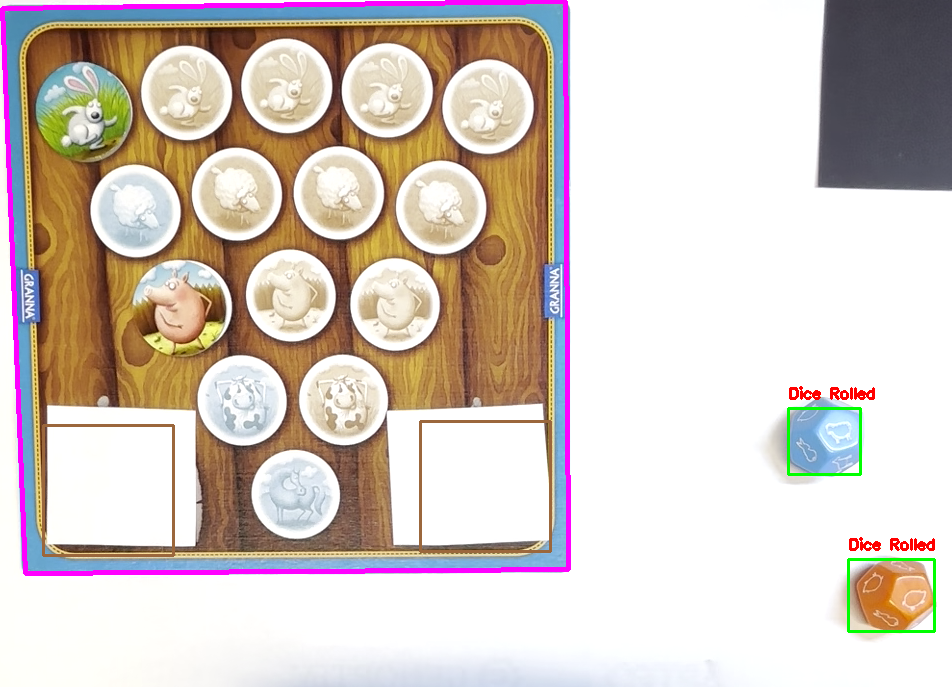

In [4]:
import cv2
import numpy as np
import time

def reorder_corners(corners):
    # Sort the points based on their x and y coordinates
    sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
    top_left, top_right = sorted_corners[:2]
    bottom_left, bottom_right = sorted_corners[2:]

    # Further sort the top-left and top-right by their y-coordinate
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left

    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left

    return np.array([top_left, top_right, bottom_left, bottom_right])
# Existing circle detection code
def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            approx = reorder_corners(approx.reshape(4, 2))
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 50000:
                return approx, x, y, w, h
    return None, None, None, None, None

# New dice detection code
def create_tracker(tracker_type="CSRT"):
    if tracker_type == "CSRT":
        return cv2.TrackerCSRT_create()
    elif tracker_type == "KCF":
        return cv2.TrackerKCF_create()
    return None

def draw_bbox_with_area(frame, bbox, color=(255, 255, 255)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)
    text_position = (p1[0], max(0, p1[1] - 10))
    cv2.putText(frame, "Dice", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

def is_square(bbox, tolerance=0.2):
    x, y, w, h = bbox
    aspect_ratio = w / h if w > h else h / w
    return 1 - tolerance <= aspect_ratio <= 1 + tolerance

def is_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
    orange_pixels = cv2.countNonZero(orange_mask)
    blue_pixels = cv2.countNonZero(blue_mask)
    total_pixels = w * h
    return (orange_pixels + blue_pixels) / total_pixels >= threshold

def detect_circles_and_dice_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[1]
    bottom_right = board_corners[3]
    square_side = int(w * 0.23)
    roi_size = (square_side, square_side)

    orange_lower = np.array([4, 66, 114])
    orange_upper = np.array([15, 252, 253])
    blue_lower = np.array([90, 80, 100])
    blue_upper = np.array([120, 255, 255])

    trackers = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        trackers = []
        tracker_start_times = {}

        cv2.polylines(frame, [board[[2,0,1,3]]], isClosed=True, color=(255, 0, 255), thickness=4)

        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

### DOGS
#detect dog as circles, determine dog boxes
        roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

        circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=45, param2=35, minRadius=10, maxRadius=50)

        circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=45, param2=35, minRadius=10, maxRadius=50)
#Show number of dogs
        dogs_stats1 = f"Small dogs: {np.count_nonzero(circles_right)}"
        dogs_stats2 = f"Big dogs: {np.count_nonzero(circles_left)}"
        cv2.putText(frame, dogs_stats1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)
        cv2.putText(frame, dogs_stats2, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)

#visualise left dogs
        if circles_left is not None:
            circles_left = np.uint16(np.around(circles_left))
            for circle in circles_left[0, :]:
                cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)
#visualise right dogs
        if circles_right is not None:
            circles_right = np.uint16(np.around(circles_right))
            for circle in circles_right[0, :]:
                cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

### DICES
#Not detecting inside board
        frame_with_border_masked = frame.copy()
        cv2.rectangle(frame_with_border_masked, board[0], 
                      board[3], (0, 0, 0), -1)
        
# Detect dice
        hsv_frame = cv2.cvtColor(frame_with_border_masked, cv2.COLOR_BGR2HSV)
        orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
        blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
        combined_mask = cv2.bitwise_or(orange_mask, blue_mask)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detected_bboxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if 1000 < area < 4500:
                x, y, w, h = cv2.boundingRect(contour)
                if is_square((x, y, w, h)):
                    detected_bboxes.append((x, y, w, h, area))

        current_time = time.time()
        
        for bbox_data in detected_bboxes:
            bbox = bbox_data[:4]
            is_new = True
            for tracker, tracked_bbox in trackers:
                if is_overlap(bbox, tracked_bbox):
                    is_new = False
                    break

            if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                tracker = create_tracker("KCF")
                tracker.init(frame, bbox)
                trackers.append((tracker, bbox))
                tracker_start_times[tracker] = current_time

        for i, (tracker, _) in enumerate(trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                    trackers[i] = (tracker, bbox)
                    area = bbox[2] * bbox[3]
                    draw_bbox_with_area(frame, bbox, (0, 255, 0))
#dice roll detection
                    if current_time - tracker_start_times[tracker] >= 2:
                        text_position = (bbox[0], bbox[1] - 10)
                        cv2.putText(frame, "Dice Rolled", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            
                    
                else:
                    trackers[i] = None
            else:
                trackers[i] = None

        trackers = [t for t in trackers if t is not None]
        cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.imshow("Circles and Dice in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
# detect_circles_and_dice_in_video('./materials/E1-T-W.MP4')
# detect_circles_and_dice_in_video('./materials/E2-T-L-W.MP4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
detect_circles_and_dice_in_video('./materials/H3-shake-win.MP4')

continue work here, under # DOGS. i need to parametrize hough circles so that it detects dogs well. or think of other way.

then get to work with detection of animals